# 1. Perkenalan

- Nama: Bintang Muhammad
- Batch: 6
- Class: Data Science

- Dataset: Dataset is a Bran Tumor MRI Scan, which there is MRI Scan images that HAVE Tumor on Brain and DOES NOT HAVE a Tumor on Brain
- Objective: Create a computer vision model to identify which image HAVE Brain Tumor and which image DOES NOT HAVE Brain Tumor.

# 2. Import Library

In [1]:
#import library
import pandas as pd
import numpy as np
import os
import pathlib
import glob
import os.path
from pathlib import Path
from numba import jit, cuda

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import cv2 as cv
import matplotlib.image as mpimg

- Importing library that's needed for creating the models

# 3. Data Loading

- Load the data for modelling, exploration, etc purposes

In [4]:
#mount from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#go to directory
% cd /content/gdrive/My Drive/M2P2/Train

/content/gdrive/My Drive/M2P2/Train


## Main Data Loading

- The purpose of this section is to create a Dataframe that consists of several columns which i can use as a Image Generator later or data exploration

In [ ]:
#establish path
No_Data_Path = Path("/content/gdrive/My Drive/M2P2/Train/Yes")
Yes_Data_Path = Path("/content/gdrive/My Drive/M2P2/Train/No")

#create a path for each image
No_JPG_Path = list(No_Data_Path.glob(r"*.jpg"))
Yes_JPG_Path = list(Yes_Data_Path.glob(r"*.jpg"))

- At This point, i tried to establish a path. I add JPG on the end so that i can directy 'call' the images.

In [ ]:
#append them to 1 list
Yes_No_List = []

for No_JPG in No_JPG_Path:
    Yes_No_List.append(No_JPG)
    
for Yes_JPG in Yes_JPG_Path:
    Yes_No_List.append(Yes_JPG)

- After that, i append them into a single list

In [ ]:
#get the labels
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Yes_No_List))

- On this cell, i took the label of the images

In [ ]:
#view image count
print("NO Image count: ", JPG_Labels.count("No"))
print("YES Image count: ", JPG_Labels.count("Yes"))

NO Image count:  1500
YES Image count:  1500


- I'm checking how many labels i have here, where i have 1500 images that does not have brain tumor, and i have 1500 too that have brain tumor.

In [ ]:
#create name
JPG_Path_Series = pd.Series(Yes_No_List,name="JPG").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels,name="TUMOR_CATEGORY")

- Creating a series for the columns in dataframe below

In [ ]:
#combine to dataframe
Main_Train_Data = pd.concat([JPG_Path_Series,JPG_Category_Series],axis=1)

- Combining 2 series into a dataframe 

In [ ]:
#shuffle the dataframe
Main_Train_Data = Main_Train_Data.sample(frac=1,random_state=555).reset_index(drop=True)

- Shuffling the rows inside the dataframe

In [ ]:
#load image shape to dataframe
idx=Main_Train_Data.index
tups_shape=[]
for i in idx :
    tups_shape.append(plt.imread(Main_Train_Data['JPG'][i]).shape)
shapes=pd.DataFrame(tups_shape,columns=['Height','Width','Channel'])

#concat data
main_data=pd.concat([Main_Train_Data, shapes],axis=1)

- On this cell, i wanted to get the Height, Width, and channel of the image dimension, then i add it to the current dataframe

# 4. Data Cleaning

- The Data Cleaning process on this section is not much since it's only an image

In [ ]:
#check null values on the dataframe
main_data.isna().sum()

JPG                 0
TUMOR_CATEGORY      0
Height              0
Width               0
Channel           105
dtype: int64

- I detected 105 Image that does not have channels, i will remove this since i wanted only image with a channels 

In [ ]:
#drop null values
main_data=main_data.dropna()

- I dropped the nulls of the data

In [ ]:
#check the data type
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2895 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JPG             2895 non-null   object 
 1   TUMOR_CATEGORY  2895 non-null   object 
 2   Height          2895 non-null   int64  
 3   Width           2895 non-null   int64  
 4   Channel         2895 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 135.7+ KB


- As for the channel, i think it should be object, since it only represents a color type of the image, so i will change it to object.

In [ ]:
#drop channel that is null
main_data['Channel']=main_data['Channel'].astype('object')

- Change color channel to object

# 5. Data Exploration

- On this section, we will explore the Images Data 

In [ ]:
#view data info
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2895 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   JPG             2895 non-null   object
 1   TUMOR_CATEGORY  2895 non-null   object
 2   Height          2895 non-null   int64 
 3   Width           2895 non-null   int64 
 4   Channel         2895 non-null   object
dtypes: int64(2), object(3)
memory usage: 135.7+ KB


- This data consists of 2895 Images paths
- Some of the Image path that contains null is already removed here

In [ ]:
#check class in the folder
data_dir = pathlib.Path('/content/gdrive/My Drive/M2P2/Train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['No' 'Yes' 'best_model_ann.h5']


- There is 2 class, The one who have Brain tumor(Yes) and the one who does not have brain tumor(No) on the training datasets

In [ ]:
#view how many class
main_data.groupby(['TUMOR_CATEGORY']).count()[['JPG']]

,JPG
TUMOR_CATEGORY,
No,1471
Yes,1424


- Image that contains No Brain Tumor is 1471 Images
- Image that contains Brain Tumor (Yes) is 1424 Images
- This amount od No and Yes images of Brain Tumor is quite balanced

Text(0.5, 1.0, 'Yes')

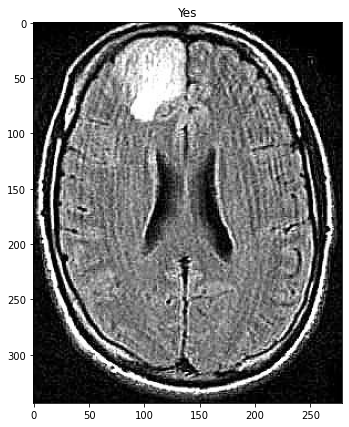

In [ ]:
#view image that have tumor
figure = plt.figure(figsize=(7,7))
plt.imshow(plt.imread(main_data["JPG"][100]))
plt.title(main_data["TUMOR_CATEGORY"][100])

- Here is an Image Example of a MRI Patient that have a Brain Tumor
- As you can see, there is some kind of 'white' area on patients that have Brain Tumors.
- Sometimes the size of the tumor varies, can be big or small, usually white
- The shape also varies, can be circular or other shape 

Text(0.5, 1.0, 'No')

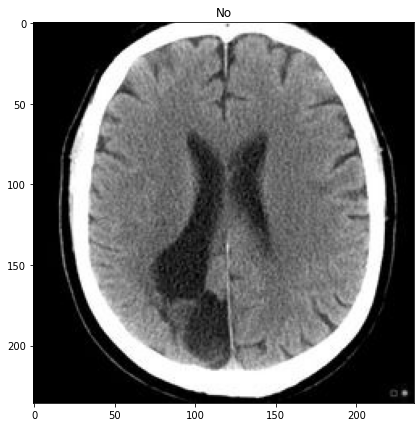

In [ ]:
#view image of brain that does not have Tumor
figure = plt.figure(figsize=(7,7))
plt.imshow(plt.imread(main_data["JPG"][4]))
plt.title(main_data["TUMOR_CATEGORY"][4])

- Here is an Image Example of a MRI Patient that does not have a Brain Tumor.
- As you can see, there are no white area on the inside of the brain image.

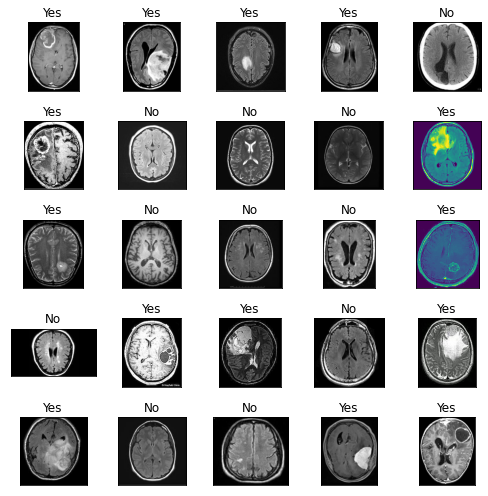

In [ ]:
#view brain Images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

- Here are some of the Image data of the Brain Images
- Some of the Image colour have Grayscale color, or sometimes dominated by purple color as the background of the MRI, and blue on the brain images

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


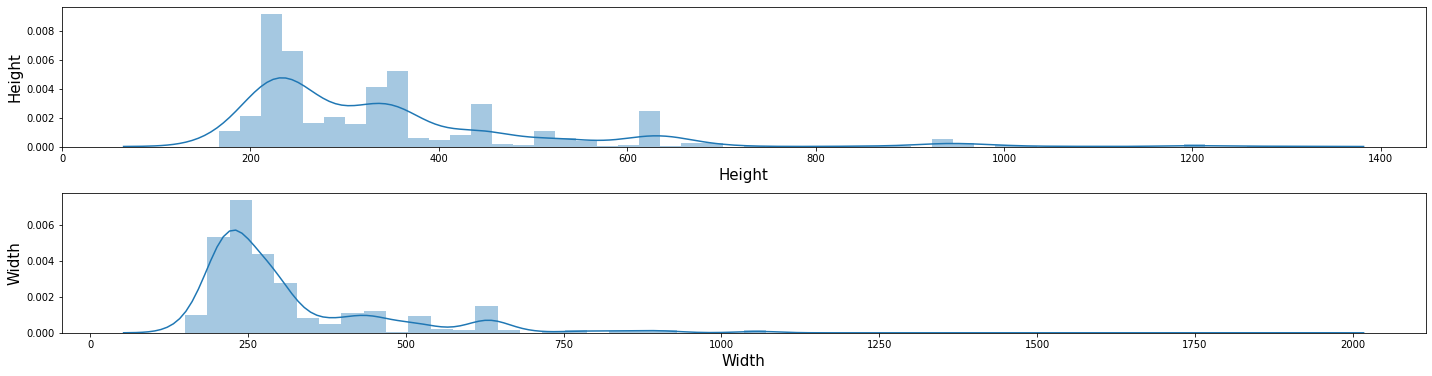

In [ ]:
#visualize data with dist plot
nums=main_data.select_dtypes(['int64','float64']).columns
plt.figure(figsize=(20, 10))
for i in range(0, len(nums)):
    plt.subplot(4,1, i+1)
    sns.distplot(main_data[nums[i]])
    plt.tight_layout()
    plt.xlabel(nums[i],fontsize=15)
    plt.ylabel(nums[i],fontsize=15)

- The Image Height of the data mostly centered around 200 - 400 pixel 
- The Image width of the data mostly centered around 125 - 500 pixel

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


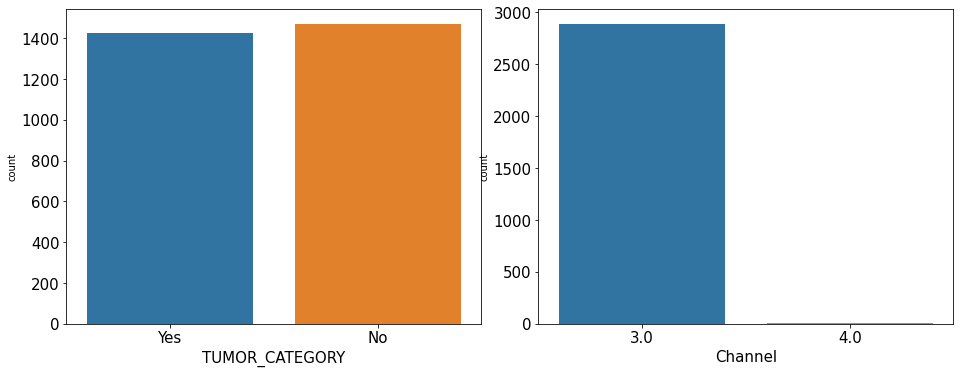

In [ ]:
#create cats columns
cats=main_data.select_dtypes(include=['object'])
cats=cats.drop(columns=['JPG']).columns

#create countplot
plt.figure(figsize=(20, 20))
for i in range(0, len(cats)):
    plt.subplot(4, 3, i+1)
    sns.countplot(main_data[cats[i]], orient='v')
    plt.tight_layout()
    plt.yticks(size=15)
    plt.xticks(size=15)
    plt.xlabel(cats[i],fontsize=15)  

- The Image of Tumor Category Labels of the Brain MRI Images looks Balanced.
- Most of the images have 3 channels rather than 4 channels

In [ ]:
#view maximum and minimum height
print('The Maximum Height is',main_data['Height'].max())
print('The Minumum Height is',main_data['Height'].min())

The Maximum Height is 1280
The Minumum Height is 167


- The Height distribution of this MRI Image is between 167 to 1280 pixel

In [ ]:
#view maximum and minimum width
print('The Maximum Width is',main_data['Width'].max())
print('The Minumum Width is',main_data['Width'].min())

The Maximum Width is 1920
The Minumum Width is 150



- The Width distribution of this MRI Image is between 150 to 1920 pixel

In [ ]:
#view channels
print('The Channels in the image is ', main_data['Channel'].unique())

The Channels in the image is  [3.0 4.0]



- Some of the Image have RGB color channels (3) and RGBA color channels (4)

## Data Explortion Summary

- The Data of Yes and No Brain Tumor is balanced
- The image have 2 kind of channels, RGB and RGBA
- The Width distribution of MRI Image is between 150 to 1920 pixel
- The Heigth distribution of MRI Image is between 167 to 1280 pixel

# 6. Data Preprocessing

- In this section, i will process the data so that it can be used for the models

## A. Splitting Train, Test and Validity Data

In [ ]:
#split data

y=main_data['TUMOR_CATEGORY']
train_data,temp_data = train_test_split(main_data,train_size=0.7,random_state=555,stratify=y)
test_data,valid_data = train_test_split(temp_data, train_size=0.5,random_state=555)

- First I split the data into 2 parts, 70% is train data 
- The rest 30% of the data, i split it evenly for test data and validity data

In [ ]:
#view train and test category
train_data.groupby(['TUMOR_CATEGORY']).count()[['JPG']]

,JPG
TUMOR_CATEGORY,
No,1029
Yes,997


- The Yes and No Images of brain tumor category looks balanced

## B. Creating Image Data Generator Pipeline

In [ ]:
#create data image pipeline for augmented image
augmented_train_datagen=ImageDataGenerator(rescale=1/255,rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

- Creating an image data generator pipepline for augmented images

In [ ]:
#create Image Data Generator Pipeline
test_datagen=ImageDataGenerator(rescale=1/255)
valid_datagen=ImageDataGenerator(rescale=1/255)

- Creating an image data generator pipeline for validity and test datasets

In [ ]:
#create data set
augment_train_set = augmented_train_datagen.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="binary",
                                                     batch_size=20,
                                                     target_size=(224,224),seed=555)

test_set = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="binary",batch_size=20,
                                                     target_size=(224,224),seed=555)

valid_set = valid_datagen.flow_from_dataframe(dataframe=valid_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="binary",batch_size=20,
                                                     target_size=(224,224),seed=555)


Found 2026 validated image filenames belonging to 2 classes.
Found 434 validated image filenames belonging to 2 classes.
Found 435 validated image filenames belonging to 2 classes.


I Created 3 dataset: 
- Augmented Image Train set For Training
- Valid set for validity
- Test set for testing the images

In [ ]:
#check shape
for data_batch,label_batch in augment_train_set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 224, 224, 1)
LABEL SHAPE:  (20,)


In [ ]:
#check shape
for data_batch,label_batch in test_set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 224, 224, 1)
LABEL SHAPE:  (20,)


In [ ]:
#check shape
for data_batch,label_batch in valid_set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 224, 224, 1)
LABEL SHAPE:  (20,)


- The shape of each dataset and it's labels is already in uniform

# 7. Define Model

- On This Section, i wil define 2 types of model and see which one performs better later on
- I will use recall since i want to reduce false negatives
- And Since the data is balanced, i will use Accuracy as supporting metrics

## A. Define First Model

In [ ]:
#define model
np.random.seed(555)
tf.random.set_seed(555)

modelseq=Sequential()

#filter model

#1
modelseq.add(Conv2D(15,3,activation='relu',input_shape=(224,224,1)))
modelseq.add(MaxPool2D(2))
#2
modelseq.add(Conv2D(30,3,activation='relu'))
modelseq.add(MaxPool2D(2))
#3
modelseq.add(Conv2D(60,3,activation='relu'))
modelseq.add(MaxPool2D(2))
#4
modelseq.add(Conv2D(120,3,activation='relu'))
modelseq.add(MaxPool2D(2))
#5
modelseq.add(Conv2D(240,3,activation='relu'))
modelseq.add(MaxPool2D(2))

#flatten
modelseq.add(Flatten())

#main model

#1
modelseq.add(Dense(80,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())


#2
modelseq.add(Dense(72,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#3
modelseq.add(Dense(64,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#4
modelseq.add(Dense(56,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#5
modelseq.add(Dense(48,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#6
modelseq.add(Dense(40,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#7
modelseq.add(Dense(32,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#8
modelseq.add(Dense(24,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#9
modelseq.add(Dense(16,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#10
modelseq.add(Dense(8,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq.add(keras.layers.BatchNormalization())
modelseq.add(Dropout(0.2))

#end layer
modelseq.add(Dense(1,activation='sigmoid'))

modelseq.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['Accuracy','Recall','Precision'])

- The first model is built with 5 Conv2d and 5 maxpooling layer, with filter starting from 15 to 240 filters
- The hidden layers used is 10 layers starting from 80 nodes to 16 nodes
- Every hidden layers have Glorot Normal weight initilization, batch normalization and dropout 0.2
- the final layer activation function is sigmoid
- As for the compiler, the loss used is binary crossentrhopy, optimizer used is sgd, and the metrics is Accuracy, Recall and Precision

## B. Define Second Model

In [ ]:
#define model
np.random.seed(555)
tf.random.set_seed(555)

modelseq2=Sequential()

#filter model

#1
modelseq2.add(Conv2D(15,3,activation='relu',input_shape=(224,224,1)))
modelseq2.add(MaxPool2D(2))
#2
modelseq2.add(Conv2D(30,3,activation='relu'))
modelseq2.add(MaxPool2D(2))
#3
modelseq2.add(Conv2D(60,3,activation='relu'))
modelseq2.add(MaxPool2D(2))
#4
modelseq2.add(Conv2D(120,3,activation='relu'))
modelseq2.add(MaxPool2D(2))
#5
modelseq2.add(Conv2D(240,3,activation='relu'))
modelseq2.add(MaxPool2D(2))
#6
modelseq2.add(Conv2D(280,3,activation='relu'))
modelseq2.add(MaxPool2D(2))


#flatten
modelseq2.add(Flatten())

#main model

#1
modelseq2.add(Dense(300,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())


#2
modelseq2.add(Dense(260,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#3
modelseq2.add(Dense(220,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#4
modelseq2.add(Dense(180,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#5
modelseq2.add(Dense(140,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))


#6
modelseq2.add(Dense(100,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#7
modelseq2.add(Dense(80,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))


#8
modelseq2.add(Dense(60,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#9
modelseq2.add(Dense(40,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#10
modelseq2.add(Dense(32,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#11
modelseq2.add(Dense(24,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#12
modelseq2.add(Dense(16,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#13
modelseq2.add(Dense(8,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#14
modelseq2.add(Dense(4,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelseq2.add(keras.layers.BatchNormalization())
modelseq2.add(Dropout(0.1))

#end layer
modelseq2.add(Dense(1,activation='sigmoid'))

modelseq2.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['Accuracy','Recall','Precision'])

- The 2nd model is built with 6 Conv2d and  maxpooling layer, with filter starting from 15 to 280 filters
- The hidden layers used is 14 layers starting from 300 nodes to 4 nodes
- Every hidden layers have Glorot Normal weight initilization, batch normalization and dropout 0.1
- the Last layer activation function is sigmoid
- As for the compiler, the loss used is binary crossentrhopy, optimizer used is sgd, and the metrics is Accuracy, Recall and Precision

# 8.Train Model

- This section wil Train the first and 2nd architecture of the model

In [ ]:
#train first model
hist_aug = modelseq.fit(augment_train_set,epochs=30,batch_size=16,validation_data=valid_set,verbose=0)

In [ ]:
#train second model
hist_imp = modelseq2.fit(augment_train_set,epochs=30,batch_size=16,validation_data=valid_set,verbose=0)

- Both of the models uses 30 epoch and divided the data into 16 batches

# 9. Model Evaluation

- This section will evaluate the first and second model

## A. First Model Evaluation

In [ ]:
#test model
ypred = modelseq.predict(test_set)
ytest=test_set.classes
thres = 0.5
res = (ypred > thres).T
res = res.astype(int)[0]

data=ypred.tolist()

print(classification_report(ytest, res))

              precision    recall  f1-score   support

           0       0.50      0.44      0.47       224
           1       0.47      0.53      0.50       210

    accuracy                           0.49       434
   macro avg       0.49      0.49      0.49       434
weighted avg       0.49      0.49      0.49       434



- The recall for this first model(0.53) is bad decent. This means that there's so many false negative values that almost the same as the true positives values
- The accuracy too, is quite low(0.49), means we only have 49% right predictions.

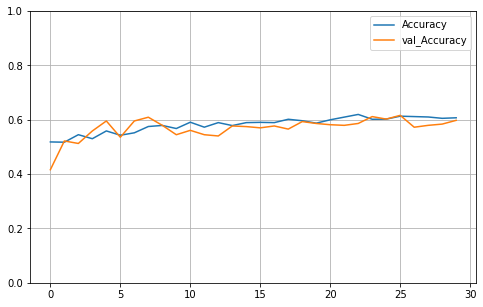

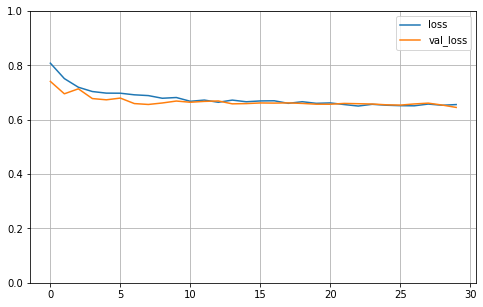

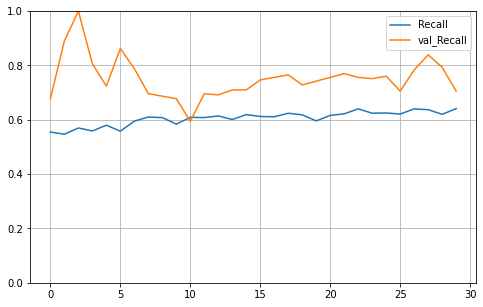

In [ ]:
# visualize the chart

pd.DataFrame(list(zip(hist_aug.history['Accuracy'],hist_aug.history['val_Accuracy'])),
               columns =['Accuracy', 'val_Accuracy']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)


pd.DataFrame(list(zip(hist_aug.history['loss'],hist_aug.history['val_loss'])),
               columns =['loss', 'val_loss']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

pd.DataFrame(list(zip(hist_aug.history['recall'],hist_aug.history['val_recall'])),
               columns =['Recall', 'val_Recall']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

- The Accuracy, validity accuracy,Loss validity loss does not variates much. They stay close to each other and almost stays inline. This means that the model does not learn much.
- The validity recall however, varies very much and there is a gap between the validity and train recall.
- The validity recall line is higher than the recall, this means the model can reduce false negatives on new data.
- We should edit this model architecture shorter to find the best metrics. 

## B. Second Model Evaluation

In [ ]:
#test model
ypred2 = modelseq2.predict(test_set)
ytest2=test_set.classes
thres = 0.5
res2 = (ypred2 > thres).T
res2 = res2.astype(int)[0]

data=ypred2.tolist()

print(classification_report(ytest2, res2))

              precision    recall  f1-score   support

           0       0.50      0.68      0.57       224
           1       0.44      0.27      0.33       210

    accuracy                           0.48       434
   macro avg       0.47      0.47      0.45       434
weighted avg       0.47      0.48      0.46       434



- The recall for this first model(0.27) is much lower than the first model. This number means that we have 27% True positive values compared to the false negatives values. This is very low.
- The accuracy too, does not differ much than the first model (0.48), means we have 48% right predictions, this number again is quite low.

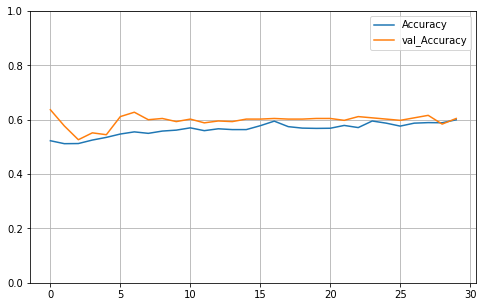

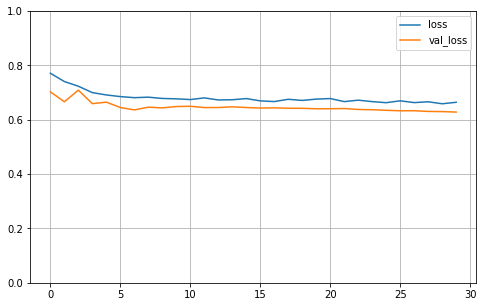

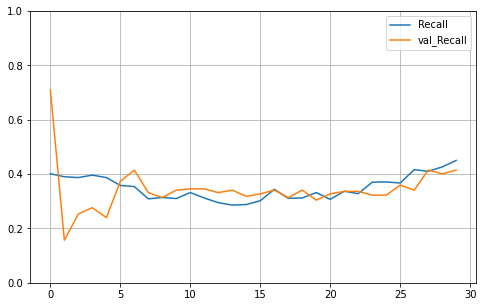

In [ ]:
# visualize the chart

pd.DataFrame(list(zip(hist_imp.history['Accuracy'],hist_imp.history['val_Accuracy'])),
               columns =['Accuracy', 'val_Accuracy']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)


pd.DataFrame(list(zip(hist_imp.history['loss'],hist_imp.history['val_loss'])),
               columns =['loss', 'val_loss']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

pd.DataFrame(list(zip(hist_imp.history['recall'],hist_imp.history['val_recall'])),
               columns =['Recall', 'val_Recall']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

- The All of the Accuracy, validity accuracy,Loss validity loss, recall and validity recall does not variates much. They stay close to each other and almost stays inline. This means that the model does not learn much.
- The validity recall and recall on this model is very low compared than previous model, therefore, we should use the first model as the base of model improvement.
- The accuracy and loss on this model is almost at the same level of the first model.

# 10. Model Improvement

- Based on model evaluation section, i choose the first model as the base model for improvement on this section

In [ ]:
#define model
np.random.seed(555)
tf.random.set_seed(555)

modelimp=Sequential()

#filter model

#1
modelimp.add(Conv2D(15,3,activation='relu',input_shape=(224,224,1)))
modelimp.add(MaxPool2D(2))
#2
modelimp.add(Conv2D(30,3,activation='relu'))
modelimp.add(MaxPool2D(2))
#3
modelimp.add(Conv2D(60,3,activation='relu'))
modelimp.add(MaxPool2D(2))

#flatten
modelimp.add(Flatten())

#main model

#1
modelimp.add(Dense(500,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelimp.add(keras.layers.BatchNormalization())
modelimp.add(Dropout(0.1))

#2
modelimp.add(Dense(200,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelimp.add(keras.layers.BatchNormalization())
modelimp.add(Dropout(0.1))

#3
modelimp.add(Dense(100,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelimp.add(keras.layers.BatchNormalization())
modelimp.add(Dropout(0.1))

#4
modelimp.add(Dense(50,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelimp.add(keras.layers.BatchNormalization())
modelimp.add(Dropout(0.1))

#5
modelimp.add(Dense(25,activation='relu',kernel_initializer=keras.initializers.GlorotNormal(seed=555)))
modelimp.add(keras.layers.BatchNormalization())
modelimp.add(Dropout(0.1))


#end layer
modelimp.add(Dense(1,activation='sigmoid'))

modelimp.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['Accuracy','Recall','Precision'])

- For the improvements, The hidden layers starts the node from 500 to 25 instead of from 80
- Also add dropout in the first hidden layer, and reduced the convolutional and maxpooling layers by 2 layers, and reduced the hidden layers by 5 layers.

In [ ]:
#train improvement model
hist_new = modelimp.fit(augment_train_set,epochs=30,batch_size=16,validation_data=valid_set,verbose=0)

- Train the improved model with the train data

In [ ]:
#test model
ypred_new = modelimp.predict(test_set)
ytest_new=test_set.classes
thres = 0.5
res_new = (ypred_new > thres).T
res_new = res_new.astype(int)[0]

data_new=ypred_new.tolist()

print(classification_report(ytest_new, res_new))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       224
           1       0.45      0.38      0.41       210

    accuracy                           0.47       434
   macro avg       0.47      0.47      0.47       434
weighted avg       0.47      0.47      0.47       434



- The result however,is not better than the first original model
- The recall decreased significantly
- The accuracy slightly increased, but does not worth it compared to the decrease in recall

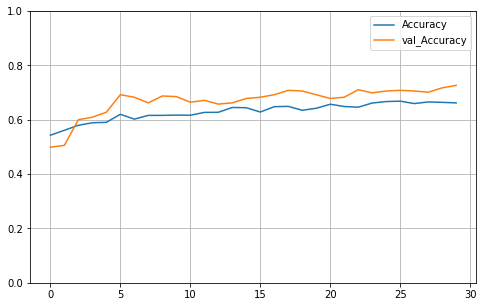

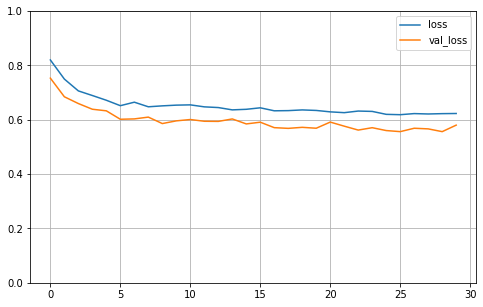

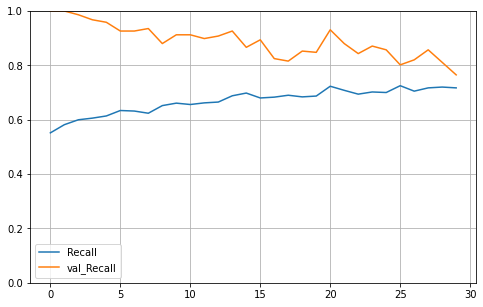

In [ ]:
# visualize the chart

pd.DataFrame(list(zip(hist_new.history['Accuracy'],hist_new.history['val_Accuracy'])),
               columns =['Accuracy', 'val_Accuracy']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)


pd.DataFrame(list(zip(hist_new.history['loss'],hist_new.history['val_loss'])),
               columns =['loss', 'val_loss']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

pd.DataFrame(list(zip(hist_new.history['recall'],hist_new.history['val_recall'])),
               columns =['Recall', 'val_Recall']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

- The Validity Accuracy is now higher than the accuracy, this means that the model may can predict better slightly.
- The recall graph overall position too is higher than the first model and more fluctative and have more distance between the recall and val recall
- The loss however, does not differ much.
- We may need more epoch and more simpler model to make this model better.
- However, because this model have worse recall than the first model, i will save the first model as the best model.

# 11. Model Saving

- On This section, i will save the best model for deployment

In [ ]:
#save the first model
modelseq.save('best_model_ann.h5')

- Saving The best model (modelseq)

In [ ]:
#view model shape
cnn_model=tf.keras.models.load_model('best_model_ann.h5')
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 15)      150       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 111, 111, 15)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 109, 109, 30)      4080      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 54, 54, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 52, 52, 60)        16260     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 26, 26, 60)      

- There is a total 848.179 parameters on this model, with the trainable parameters is 847.299 parammeters and non traianble parameters is 880 parameters.

# 12. Model Inference (With Best Model)


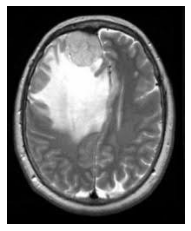

In [23]:
#show image that will be used for inference
new_img = mpimg.imread("/content/gdrive/My Drive/M2P2/Pred/Pred/pred5.jpg")
plt.imshow(new_img)
plt.axis(False);

- The image is someone with a brain tumor

In [43]:
#define function for image preprocessing
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img2 = tf.image.decode_image(img, channels=1)
  img3 = tf.image.resize(img2, size = [img_shape, img_shape])
  img4 = img3/255.
  return img4

In [44]:
#process the image to predict
new_imgs = load_and_prep_image("/content/gdrive/My Drive/M2P2/Pred/Pred/pred5.jpg")

In [46]:
#show the image shape before and after processing
print(f"Ukuran gambar awal: {new_imgs.shape}")
new_imga = tf.expand_dims(new_imgs, axis=0) 
print(f"Shape after new dimension: {new_imga.shape}")

Ukuran gambar awal: (224, 224, 1)
Shape after new dimension: (1, 224, 224, 1)


- The image before preprocessing is (224, 224, 1)
- The image after preprocessing is (1, 224, 224, 1)

In [ ]:
#predict the image
pred = modelseq.predict(new_imga)
result=pred.argmax(axis=1)
print(result)

[0]


In [ ]:
#view classes
augment_train_set.class_indices

{'No': 0, 'Yes': 1}

- The result of the image is 0, means having no cancer.
- But the truth is this brain here is having a cancer

# 13. Model Summary

- The first model(modelseq) is better because it gave the better recall results, even though it have smaller accuracy.
- However, from the model inference, the model misclassify the image.
- However, the learning rate on model improvement is better on the recalls and accuracy, so if we wanted to improve model, better improve from the modelimp model,but remember this model have a lower recall.
- It is better to improve this model first than to use it on real MRI photos, because it can give false informations.

